# Exploratory Data Analysis

## Word2Vec Model Creation

In [1]:
#Libraries
import nltk
import numpy as np
import pandas as pd
import gensim
from gensim import corpora, models, similarities
from gensim.models import word2vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
%matplotlib inline
%matplotlib notebook

In [2]:
#Word2Vec model creation

#Covidtweet_selective_model = gensim.models.Word2Vec(tok_corp, size=100, window=10, min_count=500, workers=4)
#Covidtweet_selective_model.save('Covidtweet_model_7.20')

#loading Word2Vec
Covidtweet_model = gensim.models.Word2Vec.load("Notebooks/Covidtweet_model_7.20")

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
#Word2Vec Vocabulary
tweet_vocab = Covidtweet_model.wv.vocab
words = len(tweet_vocab)
widget_input = list(tweet_vocab)
print(f'There are {words} words in this Word2Vec vocabulary.')

There are 8930 words in this Word2Vec vocabulary.


## Top 50 Tokens In Corpus

In [4]:
Master_tweet_df = pd.read_csv('data/Master_tweet_df.csv')
clean_tweet = Master_tweet_df['clean_text']

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


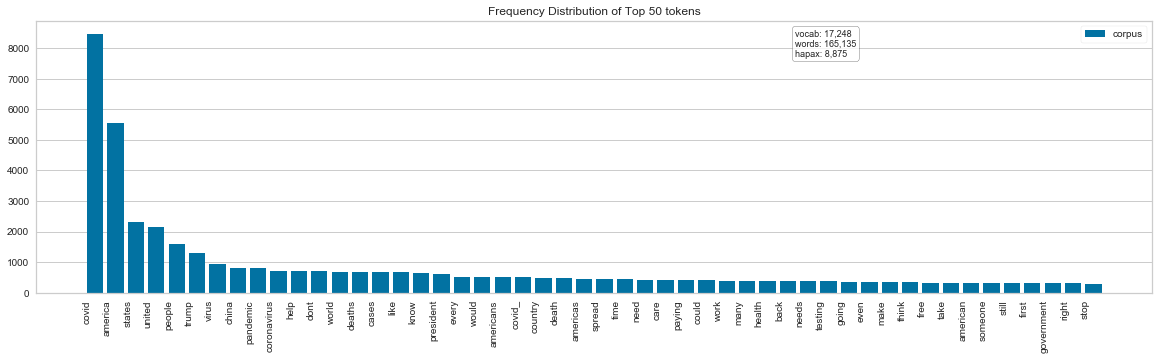

In [5]:
#top tokens
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

fig= plt.figure(figsize=(20,5))
plt.xticks(rotation=25)

vectorizer = CountVectorizer()
docs = vectorizer.fit_transform(clean_tweet)
features = vectorizer.get_feature_names()

visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [6]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=3, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [37]:
#closest word graph
#from tweet_functions import *
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(display_closestwords_tsnescatterplot,model=fixed(Covidtweet_model),word=widget_input,size=fixed(100))



interactive(children=(Dropdown(description='word', options=('united', 'states', 'leading', 'news', 'sources', …

<function __main__.display_closestwords_tsnescatterplot(model, word, size)>

## Topic Modeling with Latent Dirichlet Allocation

In [8]:
#Tweet Tokenizer 
from nltk.tokenize import TweetTokenizer
ttknz = TweetTokenizer()

#creation of the corpus
#corpus = Master_Tweet_df['clean_tweets'].astype(str)
#corpus.dtypes

#tokenizing corpus
tok_corp = []
for sent in clean_tweet:
    toked = ttknz.tokenize(sent)
    tok_corp.append(toked)

In [9]:
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary

common_dictionary = Dictionary(tok_corp)
common_corpus = [common_dictionary.doc2bow(text) for text in tok_corp]

lda = LdaModel(common_corpus, num_topics=20, alpha='auto', eval_every=5)

In [10]:
from gensim import corpora, models

list_of_list_of_tokens = list(tok_corp)
dictionary_LDA = corpora.Dictionary(list_of_list_of_tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in list_of_list_of_tokens]

num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 13.9 s, sys: 34.1 ms, total: 13.9 s
Wall time: 14.5 s


In [11]:
num_topics = 15
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    print()

5: 0.025*"home" + 0.023*"vaccine" + 0.020*"people" + 0.019*"stay" + 0.016*"happening" + 0.016*"open" + 0.015*"destroy" + 0.013*"away" + 0.013*"nursing" + 0.012*"middle"

7: 0.062*"protests" + 0.042*"states" + 0.032*"united" + 0.023*"near" + 0.019*"likely" + 0.018*"viruses" + 0.018*"chinas" + 0.017*"effort" + 0.017*"efforts" + 0.016*"civil"

6: 0.024*"china" + 0.021*"united" + 0.020*"states" + 0.015*"deaths" + 0.013*"countries" + 0.012*"cause" + 0.011*"realdonaldtrump" + 0.010*"south" + 0.010*"people" + 0.010*"world"

8: 0.027*"george" + 0.025*"country" + 0.023*"homeless" + 0.019*"service" + 0.019*"worst" + 0.016*"protection" + 0.016*"world" + 0.015*"distance" + 0.015*"years" + 0.014*"losing"

2: 0.025*"people" + 0.017*"including" + 0.014*"rate" + 0.014*"test" + 0.013*"contagious" + 0.012*"children" + 0.011*"numbers" + 0.010*"families" + 0.010*"wealth" + 0.010*"said"

4: 0.025*"lives" + 0.024*"lost" + 0.020*"opinion" + 0.020*"floyd" + 0.020*"news" + 0.018*"american" + 0.014*"employees" 

In [12]:
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


## Top N-Grams

In [13]:
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
#from nltk import bigrams
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter

In [14]:
# Getting trigrams  
vectorizer = CountVectorizer(ngram_range = (3,3)) 
X1 = vectorizer.fit_transform(clean_tweet)  
features = (vectorizer.get_feature_names()) 
#print("\n\nFeatures : \n", features) 
#print("\n\nX1 : \n", X1.toarray()) 

vectorizer = TfidfVectorizer(ngram_range = (3,3)) 
X2 = vectorizer.fit_transform(clean_tweet) 
scores = (X2.toarray()) 
#print("\n\nScores : \n", scores) 

In [15]:
sums = X2.sum(axis = 0) 
data1 = [] 
for col, term in enumerate(features): 
    data1.append( (term, sums[0,col] )) 
ranking = pd.DataFrame(data1, columns = ['term','rank']) 
words = (ranking.sort_values('rank', ascending = False)) 
print ("\n\nWords head : \n", words.head(20))



Words head : 
                                term       rank
40232            every city america  41.803077
89139           services every city  41.727705
45093     free reducedcost services  41.727705
83226    reducedcost services every  41.727705
57640               know needs help  41.617627
91613            someone know needs  41.617627
50456              help paying food  41.606915
68925             needs help paying  41.532610
61070        lists free reducedcost  41.526024
74027            paying food paying  41.165660
44445             food paying bills  41.165660
18560       city america highlights  40.991013
72952           pandemic lists free  40.952728
26825          covid pandemic lists  40.828795
12203          bills covid pandemic  40.713745
50947  highlights hundreds programs  40.511806
74017            paying bills covid  40.413924
4375    america highlights hundreds  40.371203
52482    hundreds programs designed  40.292090
79743        programs designed help  40.125

The top trigrams collected from the tweets highlight that many people were communicating about topics related to the hardships that Covid-19 has caused. From trigrams such as 'free reduced cost' to 'bills etc due' it is apparent that the financial hardships created by the pandemic remain at the forefront of this conversation.

## Tweet Analysis

In [16]:
master_tweet_df = pd.read_excel('data/Master_tweet_df.xls')
#master_tweet_df.head()

,Unnamed: 0,created_at,date,likes_count,replies_count,retweets_count,tweet,username,video,Date,...,28 days,Cases,Deaths,word_count,avg_word_length,stopwords_count,clean_text,char_count,stopwords,Sentiment
0,0,2020-05-27 01:57:20,2020-05-26,0,0,0,"Two of the United States leading news sources,...",whitewindlandon,0,2020-05-26,...,2020-06-23,2347491,121847,26,10.821429,7,united states leading news sources time today ...,332,"['of', 'the', 'and', 'these', 'do', 'not', 'or']",0.000000
1,1,2020-05-27 01:57:20,2020-05-26,0,0,0,"Two of the United States leading news sources,...",whitewindlandon,0,2020-05-26,...,2020-06-23,2347491,121847,26,10.821429,7,united states leading news sources time today ...,332,"['of', 'the', 'and', 'these', 'do', 'not', 'or']",0.000000
2,2,2020-05-26 23:18:19,2020-05-26,0,0,0,‚Ä¶Unless U‚Äôre a physician or a nurse in a s...,rescon1,0,2020-05-26,...,2020-06-23,2347491,121847,36,6.216216,16,unless physician nurse surgical room business ...,267,"['a', 'or', 'a', 'in', 'a', 'you', 'have', 'no...",0.000000
3,3,2020-05-26 23:00:14,2020-05-26,0,2,0,The reality is that Andy Beshear didn't create...,nealhead,0,2020-05-26,...,2020-06-23,2347491,121847,47,4.872340,21,reality andy beshear didnt create covid didnt ...,277,"['is', 'that', ""didn't"", 'he', ""didn't"", 'it',...",0.000000
4,4,2020-05-26 22:34:09,2020-05-26,1,0,1,"In large countries such as the United States, ...",6121el,0,2020-05-26,...,2020-06-23,2347491,121847,43,5.395349,14,large countries united states russia brazil in...,275,"['such', 'as', 'the', 'and', 'the', 'of', 'the...",0.026984


In [17]:
#performing groupby to smooth out data for graphs
groupby_df_mean = master_tweet_df.groupby(['date']).mean()
groupby_df_mean.reset_index(level=0, inplace=True)

#groupby_df_mean.columns

Index(['date', 'Unnamed: 0', 'likes_count', 'replies_count', 'retweets_count',
       'video', 'Cases_x', 'Deaths_x', 'Cases_y', 'Deaths_y', 'Cases',
       'Deaths', 'word_count', 'avg_word_length', 'stopwords_count',
       'char_count', 'Sentiment'],
      dtype='object')

The graph below provides an interactive opportunity to view the number of tweets, retweets and replies by date throughout the website.

In [36]:
import plotly.express as px
groupby_df_count = Master_tweet_df.groupby(['date']).count()
groupby_df_count.reset_index(level=0, inplace=True)
fig = px.bar(groupby_df_count, x="date", y='tweet',hover_data=['retweets_count', 'replies_count'],color='retweets_count',title="Tweet Activity")
fig.show()

In [20]:
from graphing_functions import *
    
fig = px.bar(groupby_df_count, x="date", y="likes_count", title="Count of Likes")
fig.show()

In [23]:
fig = px.scatter(Master_tweet_df,x='char_count', y="Sentiment", title = 'Character Count and Sentiment',color='char_count',trendline='ols')
fig.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



## Covid Analysis

The below interactive plot allows one to toggle between viewing the amount of Covid cases and Covid deaths in the United States. 

In [34]:
    
interact(plotly_line,x=fixed('date'),y=['Cases','Deaths'], df=fixed(Master_tweet_df))


interactive(children=(Dropdown(description='y', options=('Cases', 'Deaths'), value='Cases'), Output()), _dom_c…

<function graphing_functions.plotly_line(df, x, y)>

## State Analysis

In [25]:
#state data
state_data_df = pd.read_csv('data/state_data_raw.csv')
state_data_df = state_data_df.drop('Unnamed: 0',axis=1)

state_data_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [32]:
interact(Plotly_bar,df=fixed(state_data_df),x=fixed('state'),y=state_data_df.columns,title='State Covid Data',color='date')
#Plotly_bar(state_data_df,x='date',y='cases',title="State Cases")

interactive(children=(Dropdown(description='y', options=('date', 'state', 'fips', 'cases', 'deaths'), value='d…

<function graphing_functions.Plotly_bar(df, x, y, title, color)>

## Sentiment Analysis

In [27]:
#Sentiment analysis over time

#Sentiment_Tweet_df = pd.read_csv('data/Tweet_notebook.csv')

#Sentiment_Tweet_df.head()

Feelings_Time = Master_tweet_df[['date','Sentiment','Cases','clean_text']]

#Feelings_Time = Sentiment_Tweet_df[['date','Sentiment','Cases_x']]
#Feelings_Time['Date'] = pd.to_datetime(Feelings_Time.Date)
#Feelings_Time.sort('Date')
#Feelings_Time = Feelings_Time.sort_index()

In [28]:
#Histogram of Sentiment
import plotly.express as px

fig = px.histogram(Feelings_Time, x='Sentiment', title='Distribution of Sentiment')
fig.show()

In [22]:
interact(plotly_scatter,x=Master_tweet_df.columns,y=Master_tweet_df.columns,trendline=fixed('OLS'),color=Master_tweet_df.columns, df=fixed(Master_tweet_df))
    

interactive(children=(Dropdown(description='x', options=('Unnamed: 0', 'Unnamed: 0.1', 'created_at', 'date', '…

<function graphing_functions.plotly_scatter(df, x, y, trendline, color)>

In [29]:
#Feelings_Time.groupby('date').mean()
fig = px.bar(Feelings_Time, x='date',y='Sentiment',color='Cases', title = 'Sentiment Analysis in Relation to Cases')
fig.show()

In [35]:
fig = px.line(groupby_df_mean,x='date', y="Sentiment", title = 'Sentiment Analysis over Time')
fig.show()